In [3]:
import os
import re
import json
import gdal
import datetime
import itertools
import shapefile
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
from datetime import datetime
from itertools import product
import matplotlib.pyplot as plt
#import functions_ground_motion as fgm

import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

/usr/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
with open("../file_with_paths.json") as file_with_paths :
    FILE_PATHS = json.load(file_with_paths)

print("The base output directory is {}".format(FILE_PATHS["ground_motion_failure"]))

ground_motion_dir = FILE_PATHS["ground_motion_csv"]
ground_motion_file = ground_motion_dir + ""
# for later: this is how the ground motion data have been saved
#out_dir_csv + 'Timeseries_GroundMotion_pixel'+str(i)+'_'+str(j)+'_failure.csv'


precip_dir = FILE_PATHS["rain_intensity_caliv_valid"]
out_dir = FILE_PATHS["time_series_ml"]

# Here comes the rain again
rain_dir = FILE_PATHS["rain_dir"]
rain_file = rain_dir + "2014-01-01_to_2019-12-31_Intensity.csv"

topo_dir = FILE_PATHS["topo_dir"]
slopefile = topo_dir + "eu_dem_AoI_epsg32633_SLOPE.bil"

# road file
roaddir = FILE_PATHS["road_dir"]
roadfile = roaddir + "Road_line.shp" # this is in EPSG:32633

merged_ground_motion_distance_dir = FILE_PATHS["ground_motion_csv"]
merged_ground_motion_distance_file = merged_ground_motion_distance_dir + "merged_result.csv"



The base output directory is /exports/csce/datastore/geos/groups/LSDTopoData/FORESEE/Data/GroundMotion/Failure/


In [5]:
########## read pixel position data ##################

ground_motion_distance_pxl = pd.read_csv(merged_ground_motion_distance_file)
ground_motion_distance_pxl = np.array(ground_motion_distance_pxl)

# the first column only has indices - we don't need that.
ground_motion_distance_pxl = ground_motion_distance_pxl[:,1:]

ground_motion_distance_df = pd.DataFrame({'ground_motion': ground_motion_distance_pxl[:, 0], 'time': ground_motion_distance_pxl[:, 1], 'slope': ground_motion_distance_pxl[:,2], 'rows': ground_motion_distance_pxl[:,3],'cols': ground_motion_distance_pxl[:,4], 'distance_to_road': ground_motion_distance_pxl[:,5]})


ground_motion_distance_df['time'] =  pd.to_datetime(ground_motion_distance_df['time'])
####### need to add the rainfall data to the datafram as well. forgot to do this ###########
rain_data = pd.read_csv(rain_file)
rain_data = np.array(rain_data)
rain_data_df = pd.DataFrame({'rain_intensity_mm_sec':rain_data[:,1]})
date_list = pd.date_range(start="2014-01-01", end="2018-12-31")

rain_data_df['time'] = date_list

#print(rain_data_df.head())

# note that the ground motion data goes all the way to end of 2019 but the rainfall data is only until end of 2018
result_with_rain = pd.merge(ground_motion_distance_df, rain_data_df, how='left', on=['time'])
#print(result_with_rain.head())
result_with_rain = result_with_rain.set_index('time')
result_with_rain = result_with_rain.sort_values('time', ascending=True)
#result_with_rain.to_csv(ground_motion_dir+'merged_result_with_rain.csv')
print(result_with_rain.info(verbose=False))
# remove rows which contain missing values - these will only correspond to 2019 values, we dont have rain data for those
result_with_rain = result_with_rain.dropna()
# will bring any non numeric values to nan - easy fix- need to refine
print(result_with_rain.info(verbose=False))
#result_with_rain['ground_motion'] = result_with_rain.to_numeric(result_with_rain['ground_motion'])
result_with_rain['ground_motion'] = result_with_rain['ground_motion'].apply(pd.to_numeric, errors='coerce')
result_with_rain = result_with_rain.dropna()


# drop "rows" and "cols" dataframe columns, each column is uniquely identified by the slope and distance to road. 
result_with_rain = result_with_rain.drop(['rows', 'cols'], axis=1)
print(result_with_rain.info(verbose=False))

# delete negative ground motion values 
result_with_rain = result_with_rain[result_with_rain['ground_motion'] >= 0]
print(result_with_rain.info(verbose=False))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1425370 entries, 2014-12-31 to 2019-04-03
Columns: 6 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(1), object(5)
memory usage: 76.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1411426 entries, 2014-12-31 to 2018-12-28
Columns: 6 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(1), object(5)
memory usage: 75.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1392812 entries, 2014-12-31 to 2018-12-28
Columns: 4 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(2), object(2)
memory usage: 53.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994649 entries, 2014-12-31 to 2018-12-28
Columns: 4 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(2), object(2)
memory usage: 37.9+ MB
None


In [6]:
########### MACHINE LEARNING STUFF ########################


def regression_results(y_true, y_pred):# Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    #mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


########## define training and testing data #################
X_train = result_with_rain[:'2017'].drop(['ground_motion'], axis = 1)
y_train = result_with_rain.loc[:'2017', 'ground_motion']
X_train.info(verbose=False)

X_test = result_with_rain['2018':].drop(['ground_motion'], axis = 1)
y_test = result_with_rain.loc['2018':, 'ground_motion']
X_test.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 607291 entries, 2014-12-31 to 2017-12-27
Columns: 3 entries, slope to rain_intensity_mm_sec
dtypes: float64(1), object(2)
memory usage: 18.5+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 387358 entries, 2018-01-02 to 2018-12-28
Columns: 3 entries, slope to rain_intensity_mm_sec
dtypes: float64(1), object(2)
memory usage: 11.8+ MB


In [7]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
#models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 3))) # Ensemble method - collection of many decision trees
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

LR: -0.005437 (0.035433)
KNN: 0.721298 (0.094171)
RF: 0.493704 (0.054054)


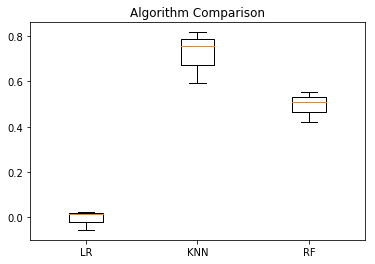

In [8]:
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=3)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [9]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [ ]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,6)]}

tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score, verbose=10)
print('done searching.Starting to train')
print('done training')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [10]:
models[1]
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [11]:
best_model = models[1]


In [12]:
y_true = y_test.values
y_pred = knn.predict(X_test)
results = regression_results(y_true, y_pred)

explained_variance:  0.8214
r2:  0.8135
MAE:  4.9241
MSE:  66.7103
RMSE:  8.1676


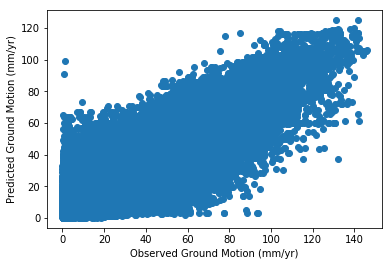

In [16]:
plt.scatter(y_true, y_pred)
plt.xlabel("Observed Ground Motion (mm/yr)")
plt.ylabel("Predicted Ground Motion (mm/yr)")
plt.savefig("predicted_obs_ground_motion_ml.png")

In [16]:
y_true

array([14.86,  1.97, 30.75, ..., 14.1 , 56.98, 52.49])

In [17]:
y_pred

array([ 3.36 ,  6.866, 29.484, ..., 14.148, 75.374, 43.24 ])

In [ ]:
result_with_rain['2018':]

In [30]:
dates = result_with_rain.index

(array([1.64846e+05, 1.11631e+05, 6.37550e+04, 2.51700e+04, 1.16450e+04,
        5.93700e+03, 2.90600e+03, 1.09100e+03, 2.92000e+02, 8.50000e+01]),
 array([  0.    ,  12.4808,  24.9616,  37.4424,  49.9232,  62.404 ,
         74.8848,  87.3656,  99.8464, 112.3272, 124.808 ]),
 <a list of 10 Patch objects>)

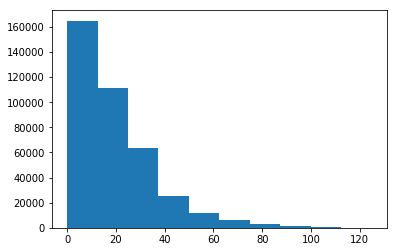

In [39]:
plt.hist(y_pred)

In [41]:
# get an array with all the predicted y values
# create a dataset where it should show dt instead of t
date_train = result_with_rain.index

array([False, False, False, ..., False, False, False])

In [44]:
dates_train = result_with_rain.index.values[:len(y_train)]
dates_test = result_with_rain.index.values[len(y_train):]

In [54]:
result_with_rain_new = result_with_rain.reset_index()

In [74]:
result_with_rain_new.head()

,time,ground_motion,slope,distance_to_road,rain_intensity_mm_sec
0,2014-12-31,6.67,0.190233,14501,0.000024
1,2014-12-31,10.20,0.107414,7250,0.000024
2,2014-12-31,18.85,0.0687284,11285,0.000024
3,2014-12-31,7.17,0.049675,641,0.000024
4,2014-12-31,6.99,0.0922319,709,0.000024


In [75]:
# get time passed dataframe
df = pd.DataFrame(index=result_with_rain.index.values, columns=['time since'])

basedate = pd.Timestamp('2014-12-31')
df['time since'] = df.apply(lambda x: (x.name.to_pydatetime() - basedate).days, axis=1)
result_with_rain['time_since'] = df['time since']

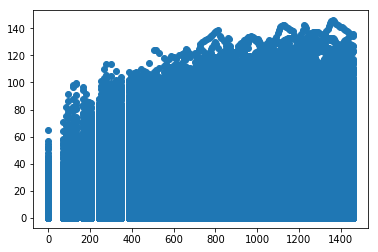

In [76]:
plt.scatter(df['time since'], result_with_rain['ground_motion'])

In [80]:
df_threshold = result_with_rain[result_with_rain['ground_motion'] >= 80]


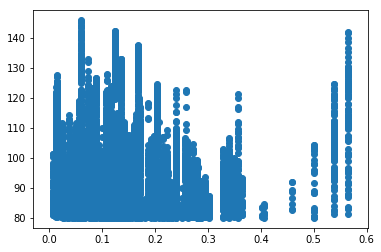

In [96]:
plt.scatter(df_threshold['slope'], df_threshold['ground_motion'])

In [ ]:
plt.hist(df_threshold['slope'])

In [91]:
df_threshold.head()

,ground_motion,slope,distance_to_road,rain_intensity_mm_sec,time_since
time,,,,,
2015-03-25,82.24,0.124795,54965,1.413031e-04,84
2015-04-06,86.17,0.076304,38530,1.639528e-06,96
2015-04-06,91.49,0.124795,54965,1.639528e-06,96
2015-04-30,87.91,0.0600391,86193,9.664785e-08,120
2015-04-30,82.12,0.127192,135865,9.664785e-08,120
